# Laser Powder Bed Fusion (LPBF) Data Processing and Analysis Notebook

## Introduction

This Jupyter Notebook serves as the central hub for processing and analyzing data collected from a series of LPBF experiments aimed at discerning transitions in melting regimes. The notebook encompasses various stages, starting from data visualization, data preprocessing, and eventually saving the processed data for further analysis.

The experiments involve printing a set of cubes (Cube 1 to Cube 5) under varying laser power and scan speed conditions. Optical emission and reflection data were collected for each condition and stored in separate files.

### Objectives
1. **Data Visualization**: To inspect and understand the structure and characteristics of the raw data.
2. **Data Preprocessing**: To prepare the data by cropping, padding, and segmenting to ensure uniformity across conditions.
3. **Data Storage**: To save the processed data into a structured format, facilitating subsequent analyses.

The notebook is structured as follows:
1. Initial Data Visualization
2. Data Preprocessing
3. Segmentation and Further Analysis
4. Data Storage


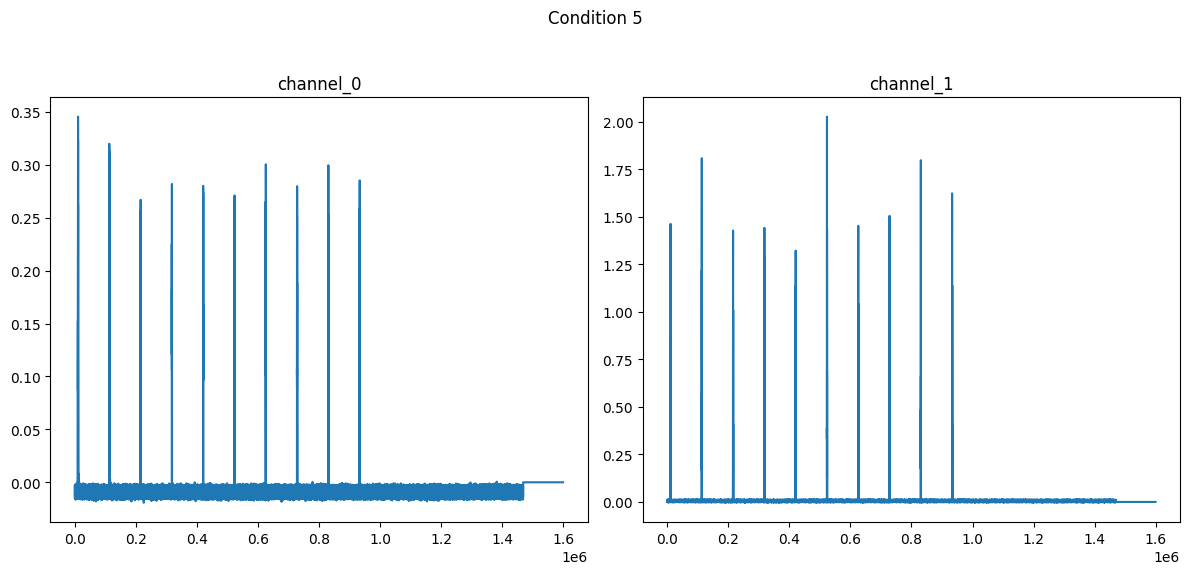

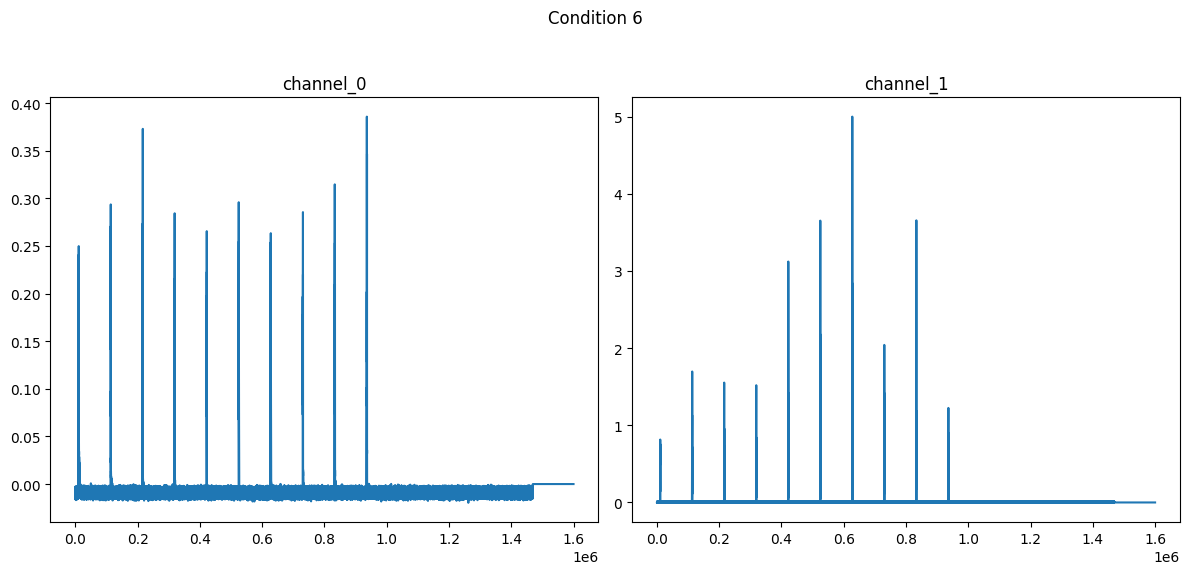

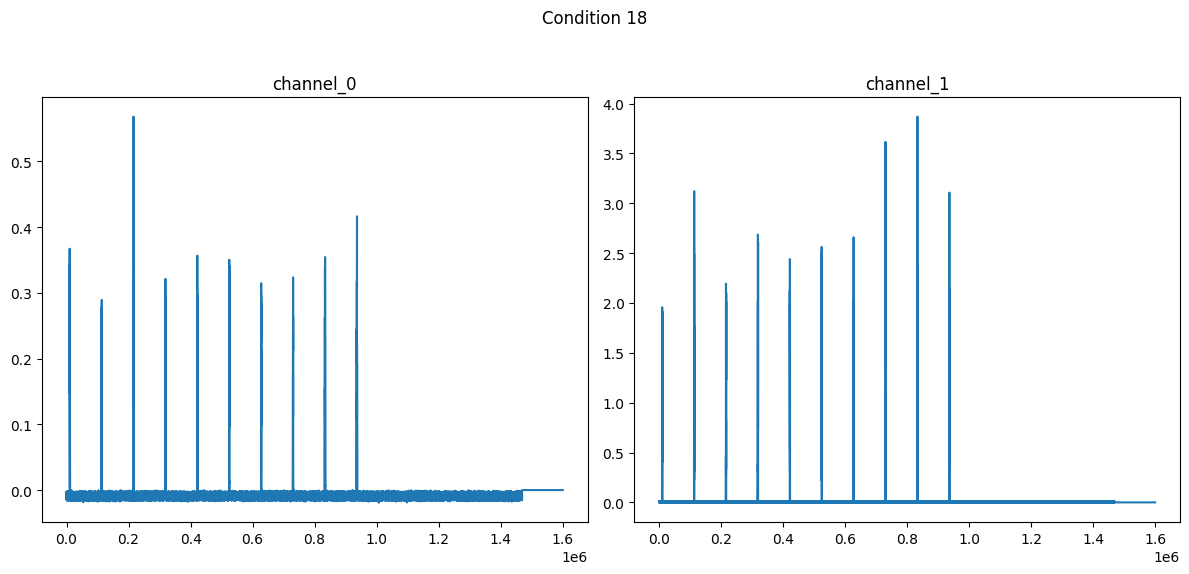

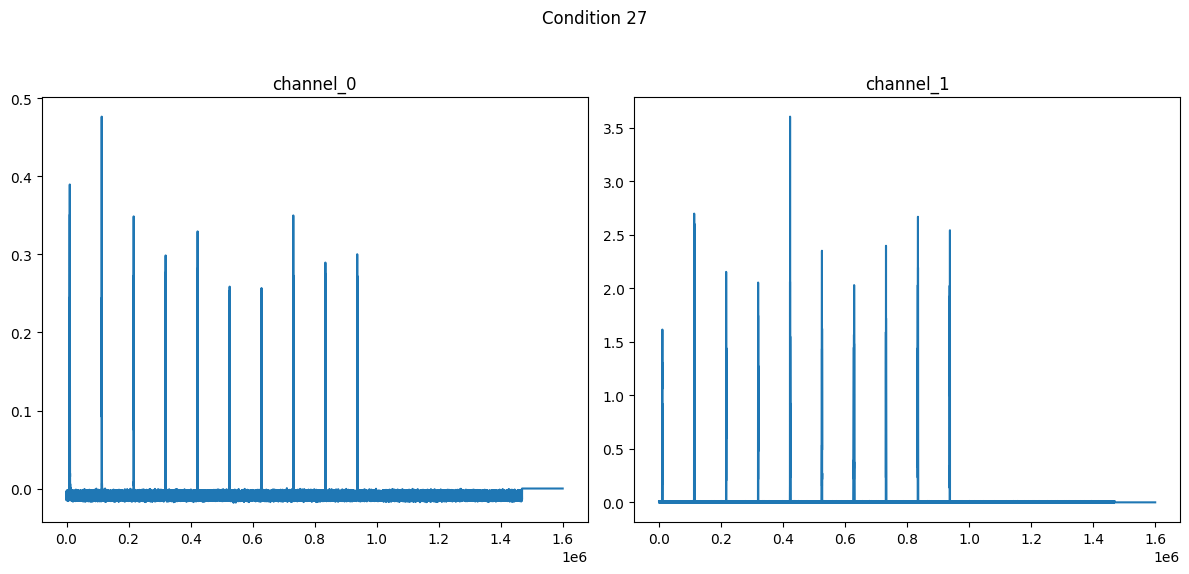

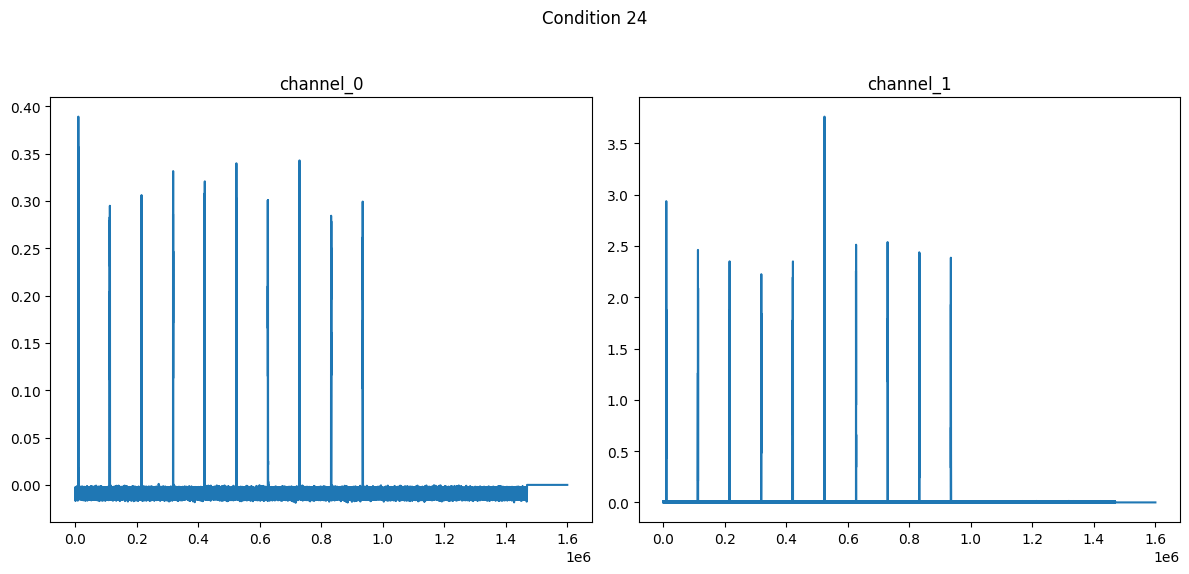

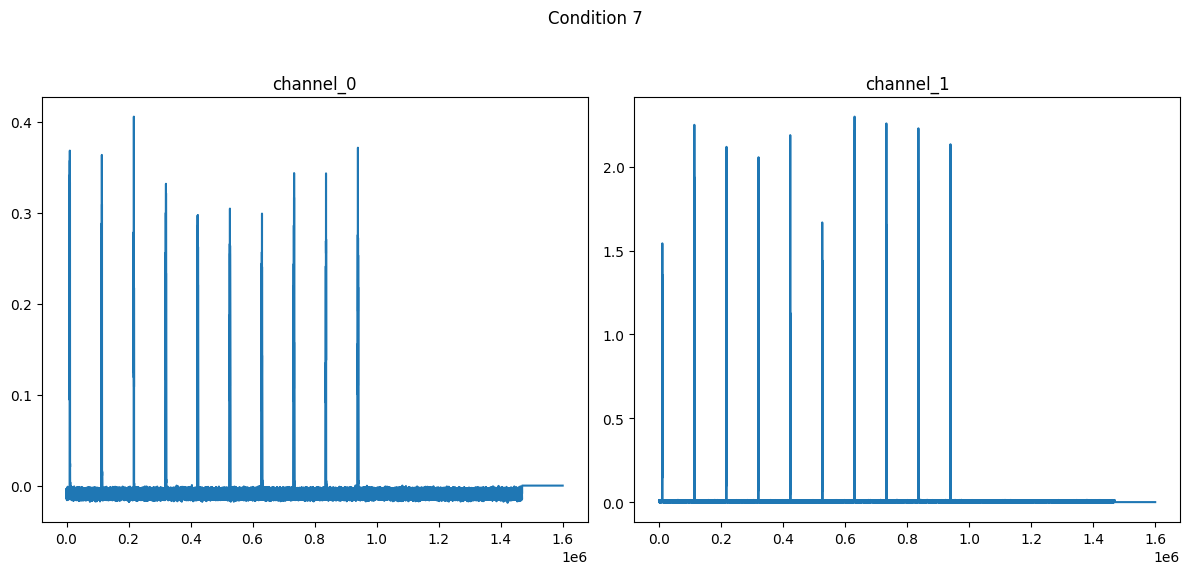

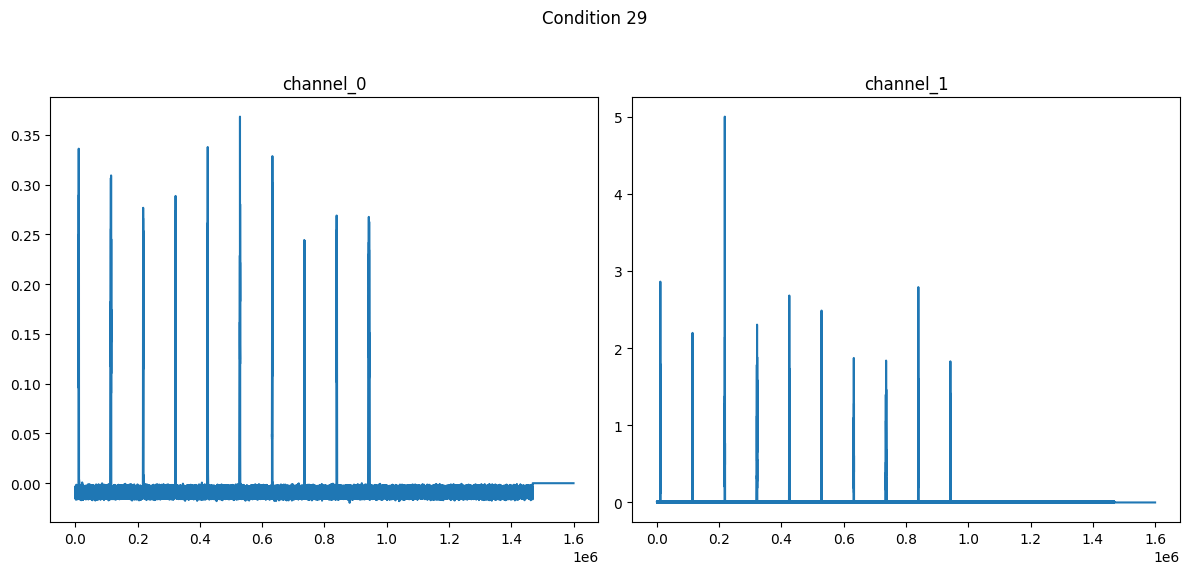

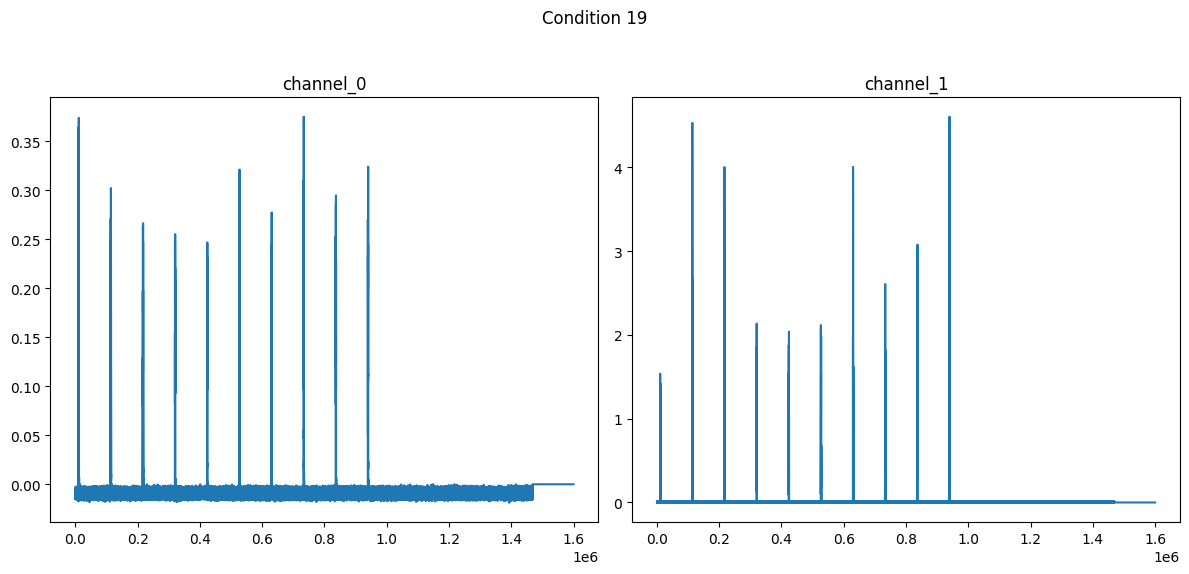

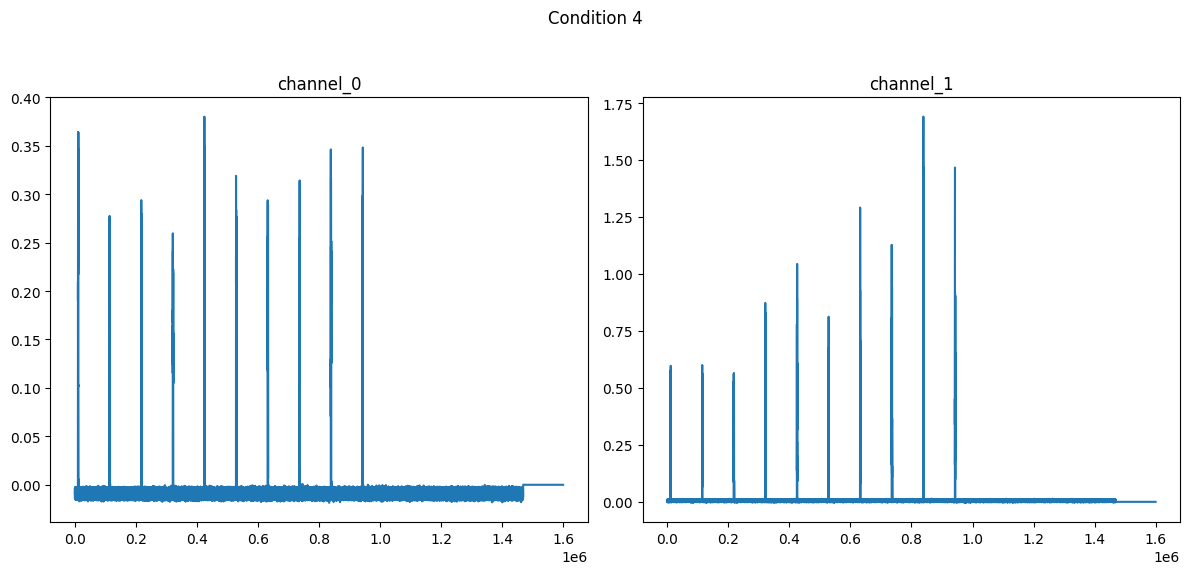

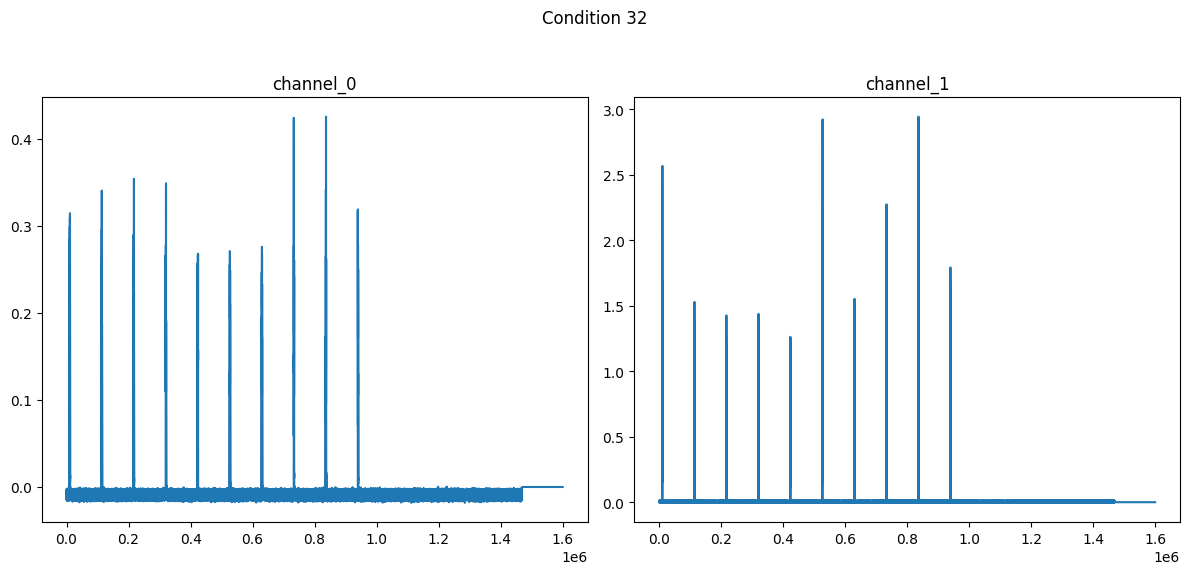

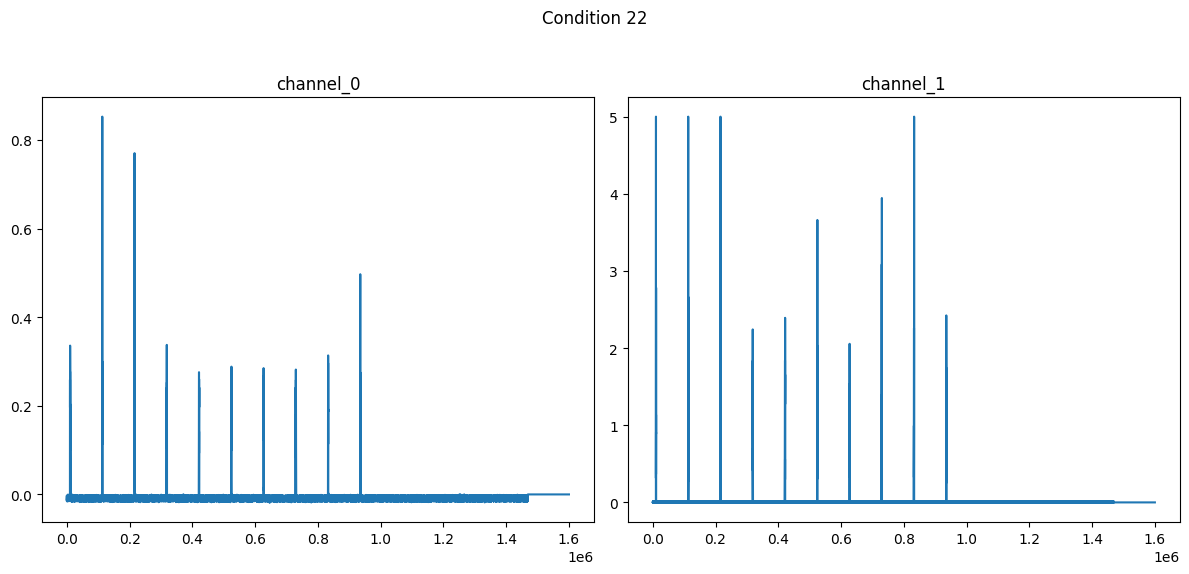

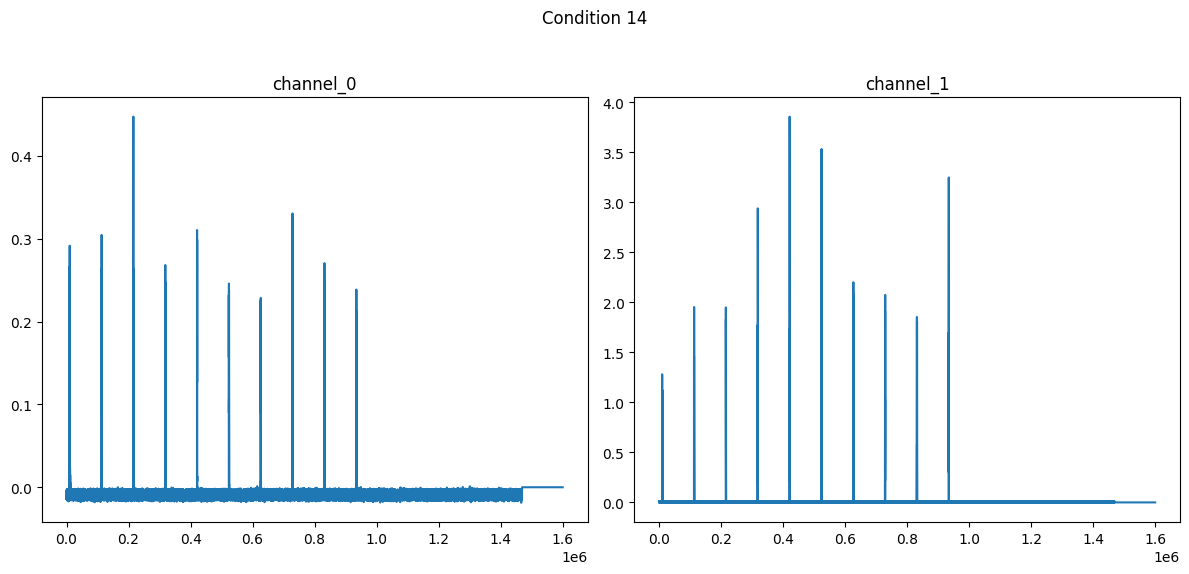

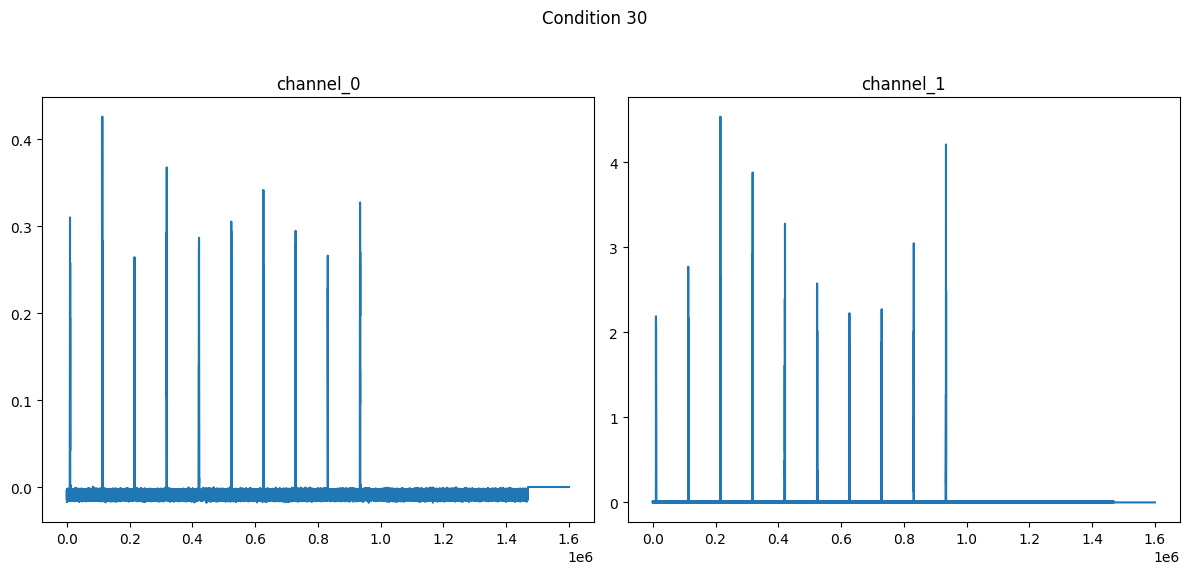

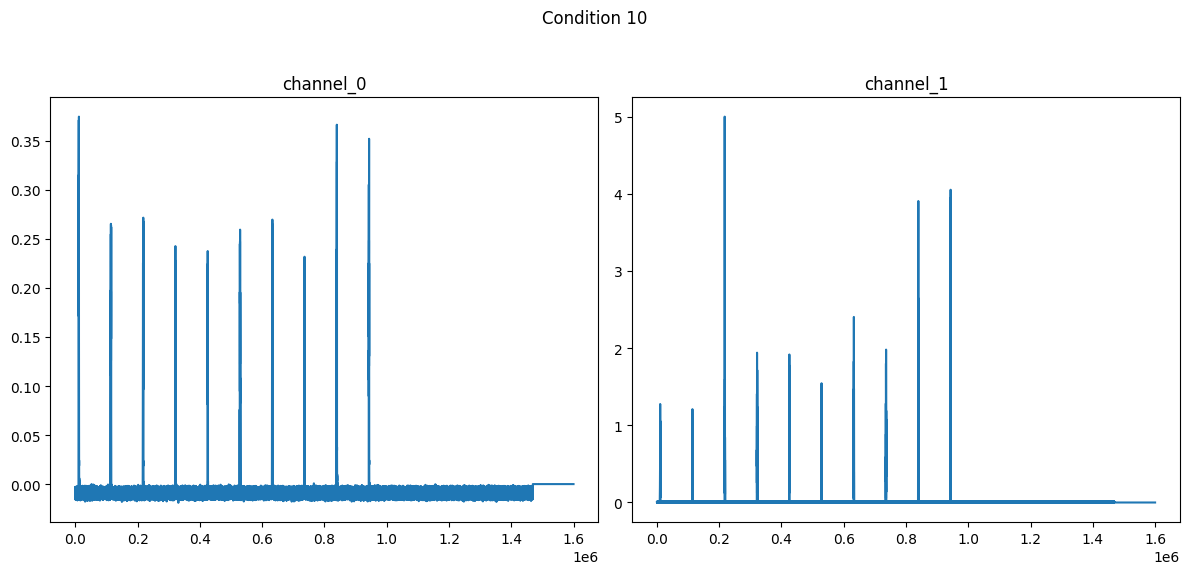

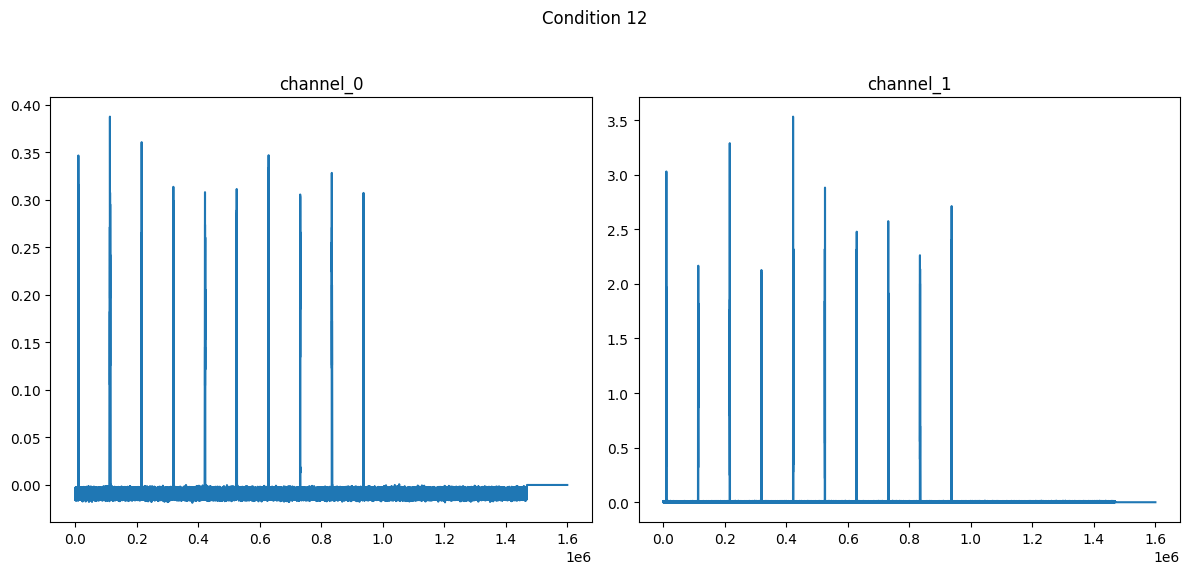

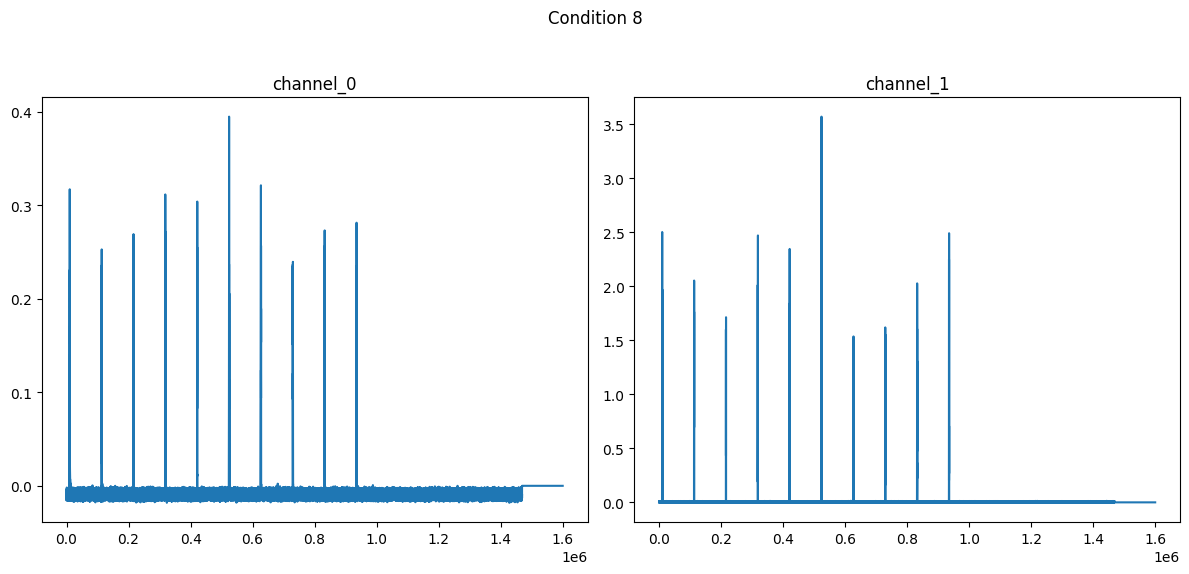

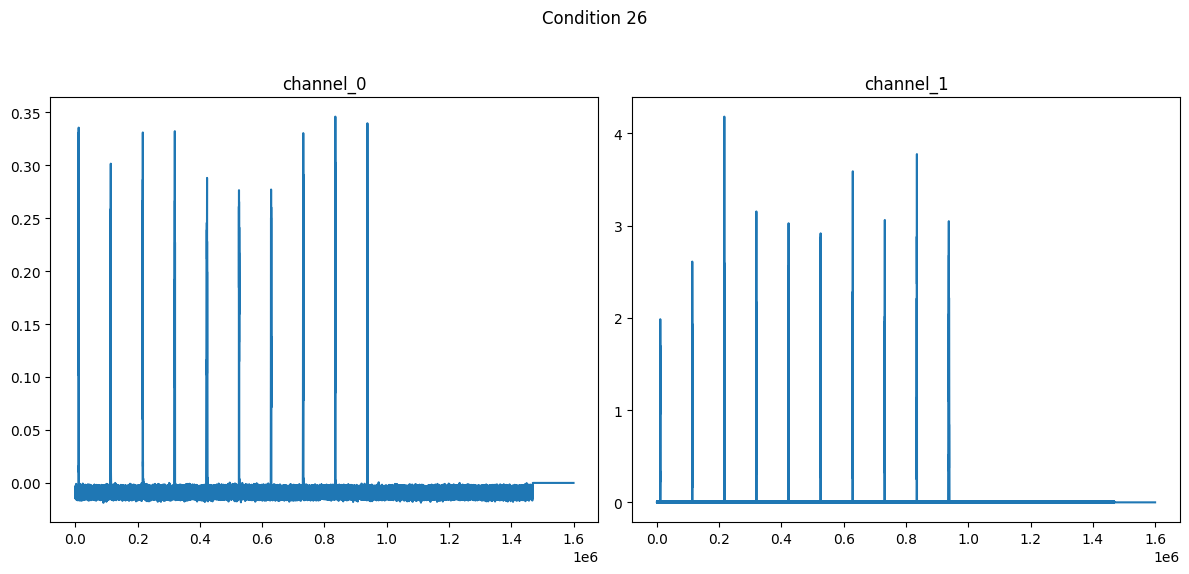

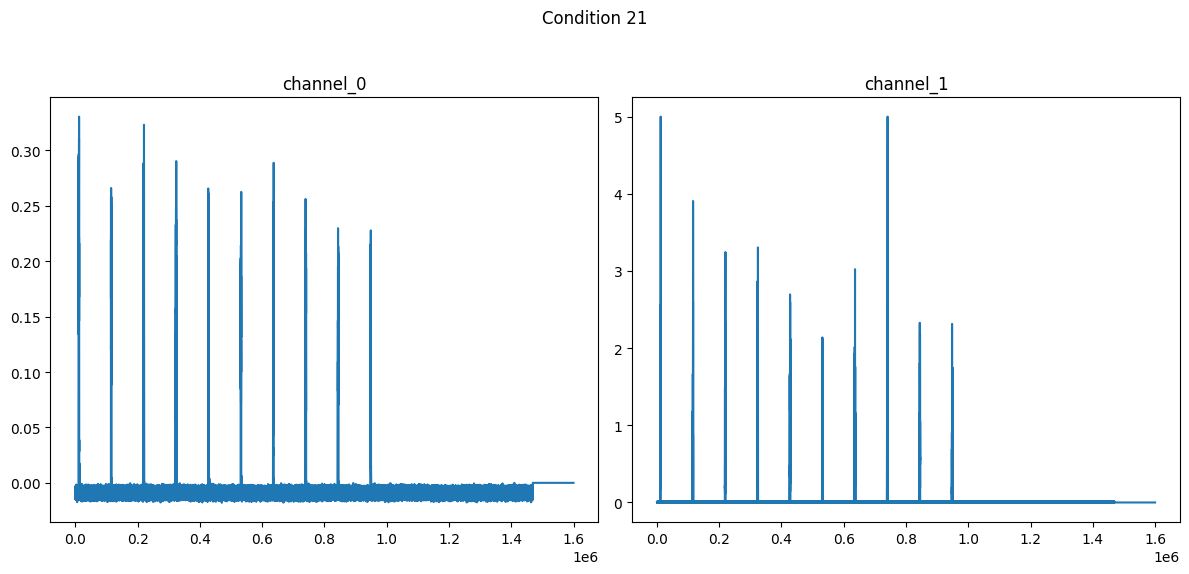

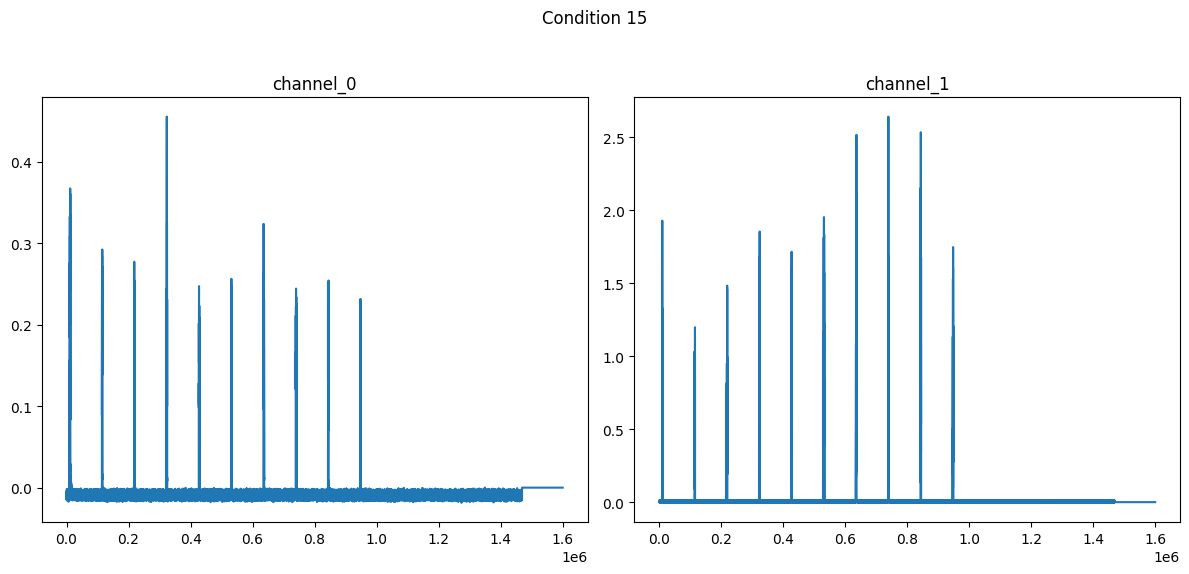

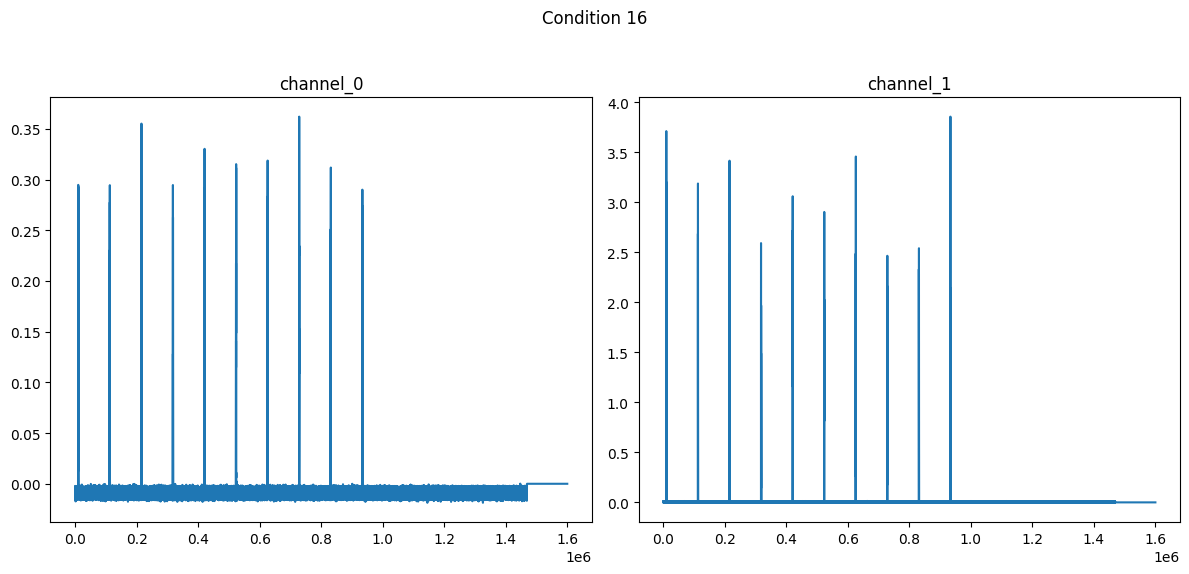

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

# Set the base folder for a specific cube
cube = 2
base_folder = f"./Data/Cube{cube}"

# Define the channels
channels = ['channel_0', 'channel_1']

# Get the list of all condition folders
condition_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

# Randomly select 20 condition folders
selected_conditions = random.sample(condition_folders, 20)

# Loop through each selected condition folder
for condition_folder in selected_conditions:
    # Extract the condition number from the folder name
    condition_number = int(condition_folder.split('_P')[-1])
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Condition {condition_number}")
    
    # Loop through each channel
    for i, channel in enumerate(channels):
        # Construct the full path to the channel folder
        channel_folder_path = os.path.join(base_folder, condition_folder, channel)
        
        # Construct the full path to the CSV file
        file_path = os.path.join(channel_folder_path, f"data_cond{condition_number}.csv")
        
        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping this condition.")
            continue
        
        # Plot the data in the corresponding subplot
        axs[i].plot(df.iloc[:, 0])
        axs[i].set_title(f"{channel}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [2]:
import os
import numpy as np
import pandas as pd


# Calculate the number of conditions (parameter sets) based on the number of condition folders
condition_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
N_conditions = len(condition_folders)

# Set a common sample_length 
sample_length = 1000000  

N_conditions

32

In [3]:
# Initialize a NumPy array with the shape (N_conditions, 2, sample_length)
data_array = np.zeros((N_conditions, 2, sample_length))

In [4]:
# Loop through each condition folder
# Sort the folders based on the extracted parameter number
for i, condition_folder in enumerate(sorted(condition_folders, key=lambda x: int(x.split('_P')[-1]))):
    # Extract the condition number from the folder name
    condition_number = int(condition_folder.split('_P')[-1])
    
    # Loop through each channel
    for j, channel in enumerate(channels):
        # Construct the full path to the channel folder
        channel_folder_path = os.path.join(base_folder, condition_folder, channel)

        # Construct the full path to the CSV file
        file_path = os.path.join(channel_folder_path, f"data_cond{condition_number}.csv")
        
        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping this condition.")
            continue

        # Check the length of the DataFrame and pad with zeros if needed
        actual_length = len(df)
        if actual_length < sample_length:
            print(f"File {file_path} needed padding.")
            padding_length = sample_length - actual_length
            padding = np.zeros(padding_length)
            padded_data = np.concatenate([df.iloc[:, 0].to_numpy(), padding])
        else:
            padded_data = df.iloc[:sample_length, 0].to_numpy()
        
        # Fill the NumPy array with the cropped (and possibly padded) data
        data_array[i, j, :] = padded_data

print("Data array created with shape:", data_array.shape)

Data array created with shape: (32, 2, 1000000)


In [5]:
folder = './Data'
save_path = os.path.join(folder, "data_array.npy")

# Save the NumPy array to a binary file
np.save(save_path, data_array)

print(f"Database saved to {save_path}")


Database saved to ./Data\data_array.npy


In [6]:
def computeBoundaries(signal, th):
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]

    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((70, 1))
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]

    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)

    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]

    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_boundaries(dataAllChann, startings, endings):
    # Number of channels and segments
    num_channels, num_segments, _ = dataAllChann.shape

    # Create a single plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Initialize a variable to keep track of the x-axis position
    x_position = 0

    # Loop through each channel and segment to plot them
    for i in range(num_channels):
        for j in range(num_segments):
            # Extract the current segment
            segment = dataAllChann[i, j, :]

            # Generate x values for the current segment
            x_values = np.arange(x_position, x_position + len(segment))

            # Plot the segment
            ax.plot(x_values, segment, label=f'Channel {i}, Segment {j}')

            # Mark the starting and ending points
            ax.scatter(x_values[0], segment[0], color='g')  # Starting point
            ax.scatter(x_values[-1], segment[-1], color='r')  # Ending point

            # Update the x_position for the next segment
            x_position = x_values[-1] + 1

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title('Segmented Signals with Start and End Points')

    # Display the plot
    plt.show()


In [8]:
num_signals = 5
# Generate num_signals random integers between 0 and N_conditions
random_conditions = np.random.randint(0, N_conditions, num_signals)
random_conditions

array([25,  5, 15, 25,  6])

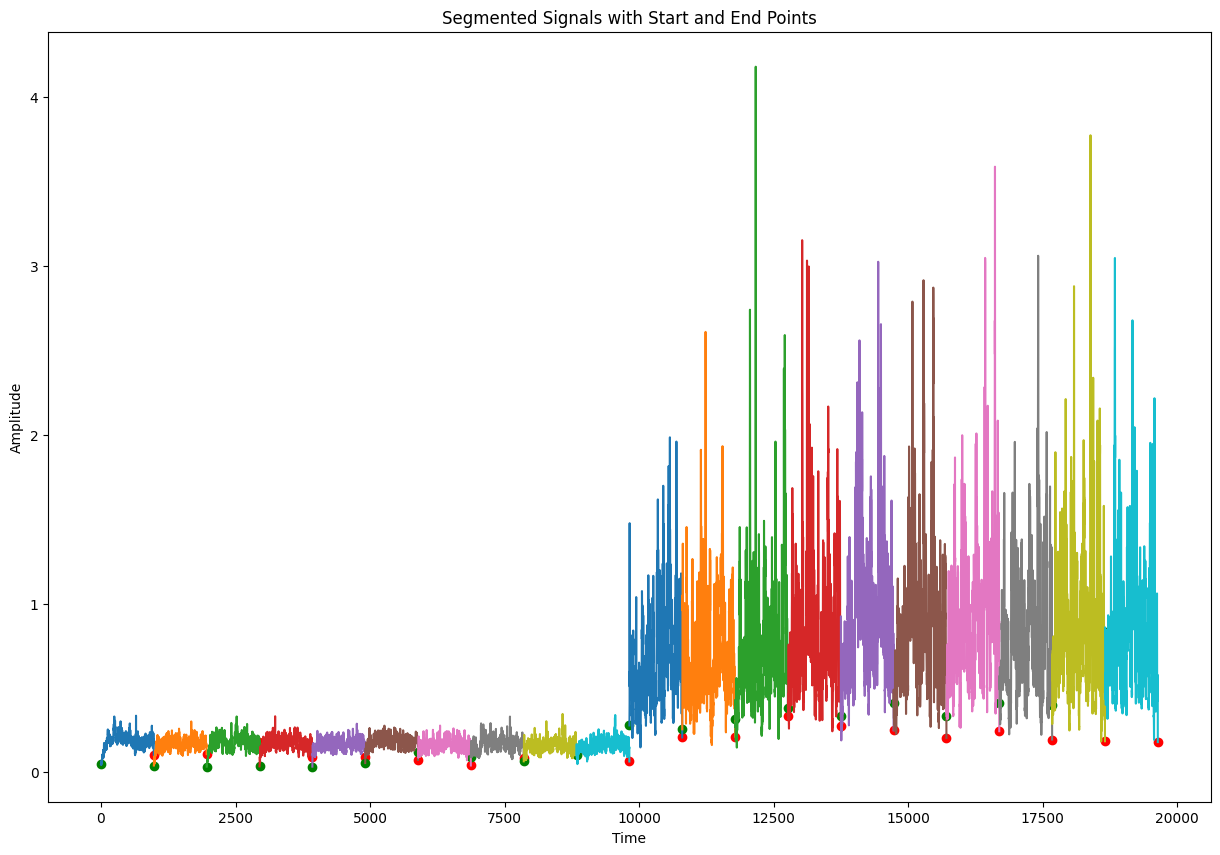

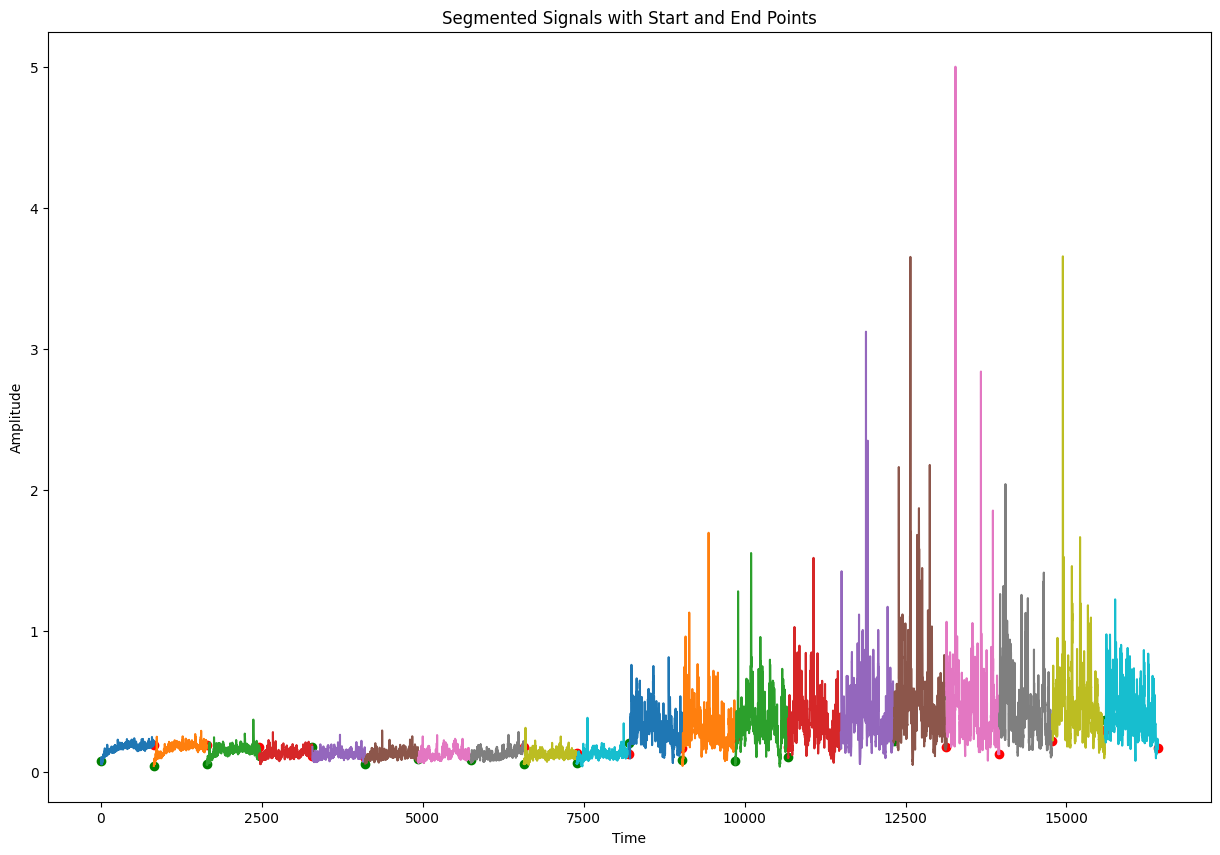

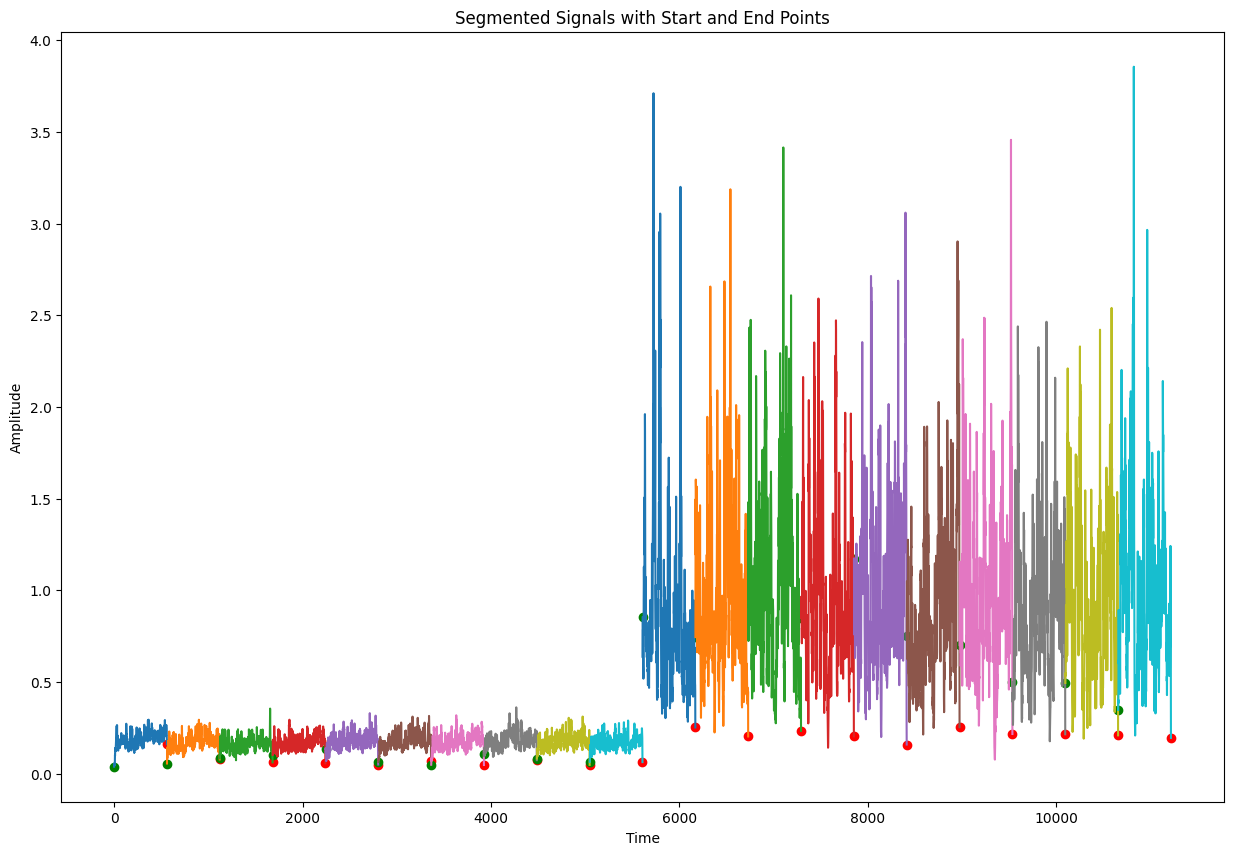

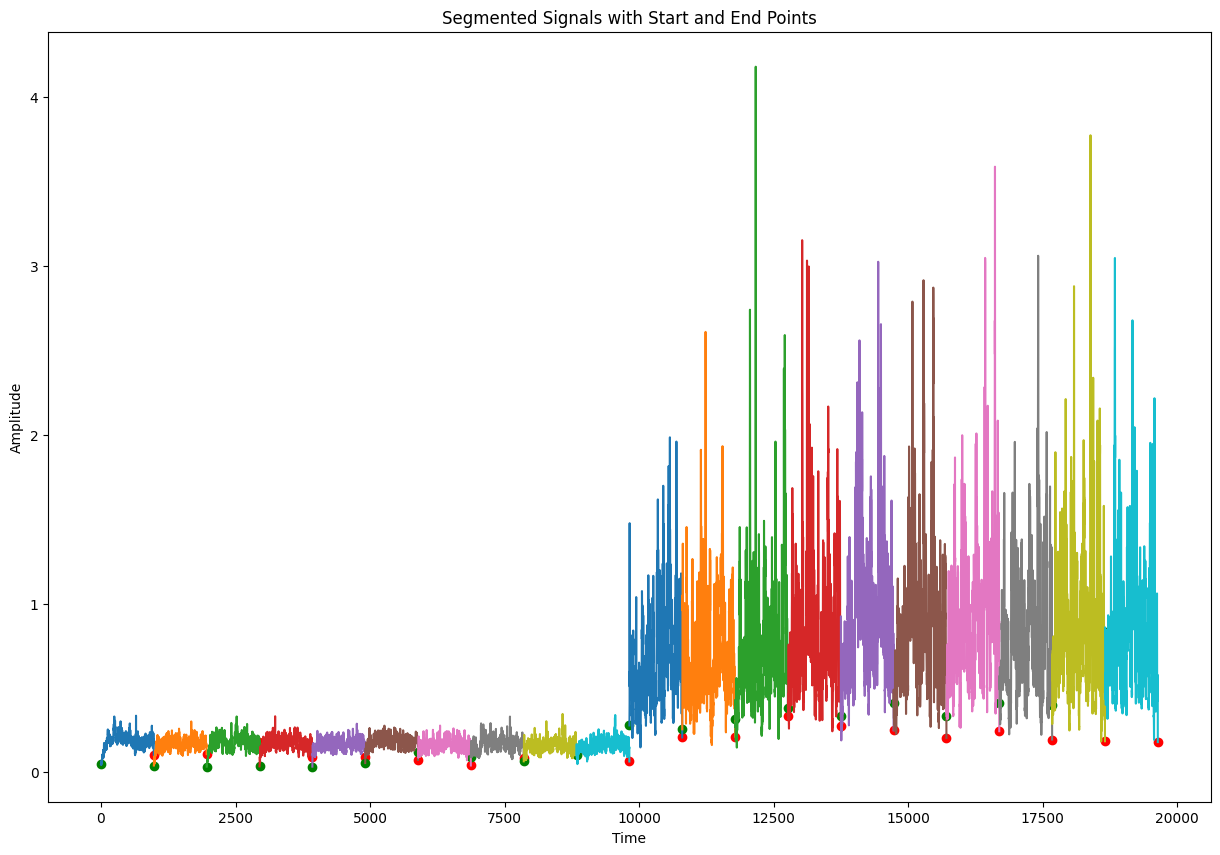

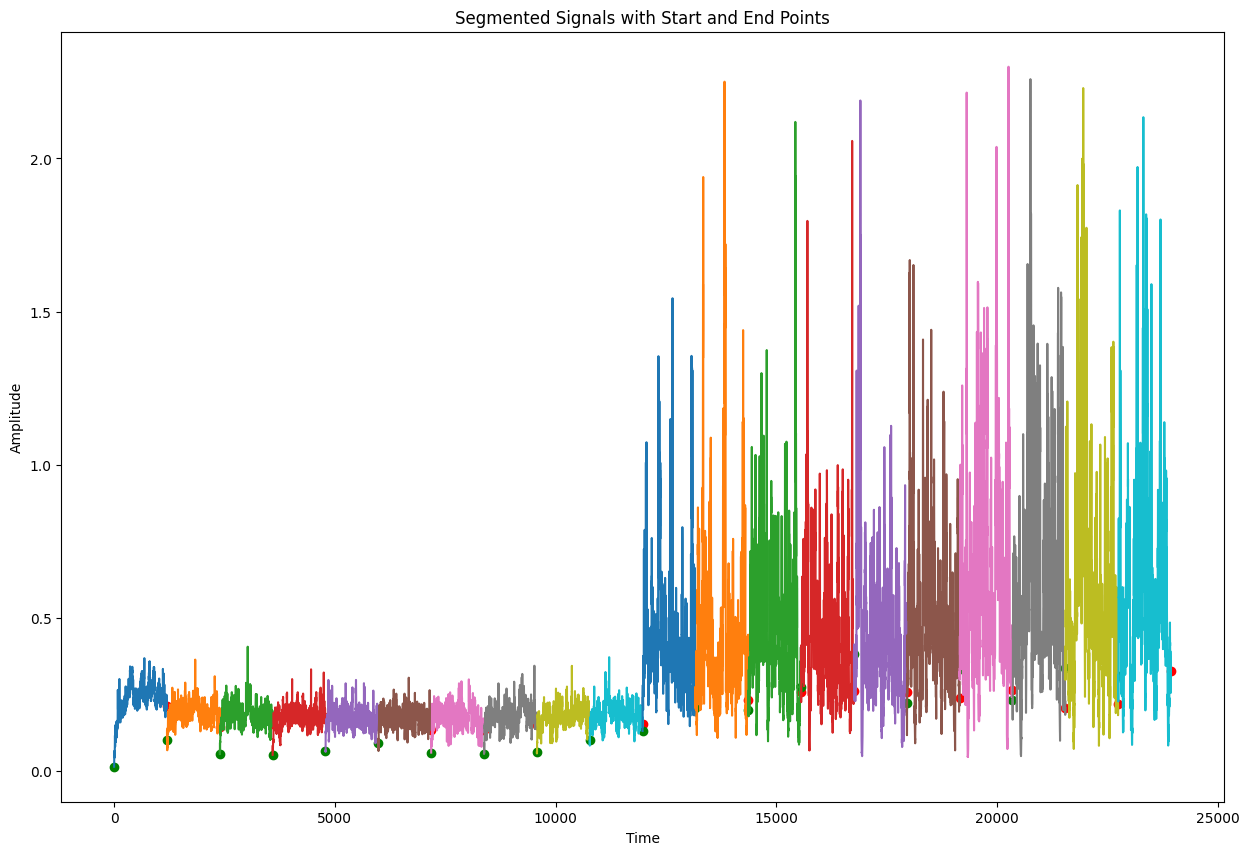

In [9]:
import skimage.morphology

# Threshold value for computeBoundaries
th = 0.1  

# Loop through the random conditions
for condition in random_conditions:
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition, 0, :]
    data_channel_1 = data_array[condition, 1, :]

    # Find the boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)
    
    # Compute size of the segments
    size_segments = ending_1 - starting_1
    
    # Get the minimum size
    min_size = min(size_segments)

    # Use these boundaries to segment both channels
    segmented_0 = [data_channel_0[end-min_size:end] for end in ending_1]
    segmented_1 = [data_channel_1[end-min_size:end] for end in ending_1]
    
    # Convert to NumPy array with the desired shape
    n_segments = len(segmented_0)  
    dataAllChann = np.zeros((2, n_segments, min_size))

    for i, segment in enumerate(segmented_0):
        dataAllChann[0, i, :] = segment[:min_size]

    for i, segment in enumerate(segmented_1):
        dataAllChann[1, i, :] = segment[:min_size]
    
    plot_signals_with_boundaries(dataAllChann, starting_1, ending_1)

In [10]:
def plot_signals_with_boundaries(data_channel_0, data_channel_1, startings, endings):
    # Create a figure with two subplots (one for each channel)
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot the data for channel_0
    axs[0].plot(data_channel_0, label='Channel 0')
    axs[0].scatter(startings, data_channel_0[startings], color='g', label='Starting points')
    axs[0].scatter(endings, data_channel_0[endings], color='r', label='Ending points')
    axs[0].legend()
    axs[0].set_title('Channel 0')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Amplitude')

    # Plot the data for channel_1
    axs[1].plot(data_channel_1, label='Channel 1')
    axs[1].scatter(startings, data_channel_1[startings], color='g', label='Starting points')
    axs[1].scatter(endings, data_channel_1[endings], color='r', label='Ending points')
    axs[1].legend()
    axs[1].set_title('Channel 1')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Amplitude')

    # Show the plot
    plt.tight_layout()
    plt.show()


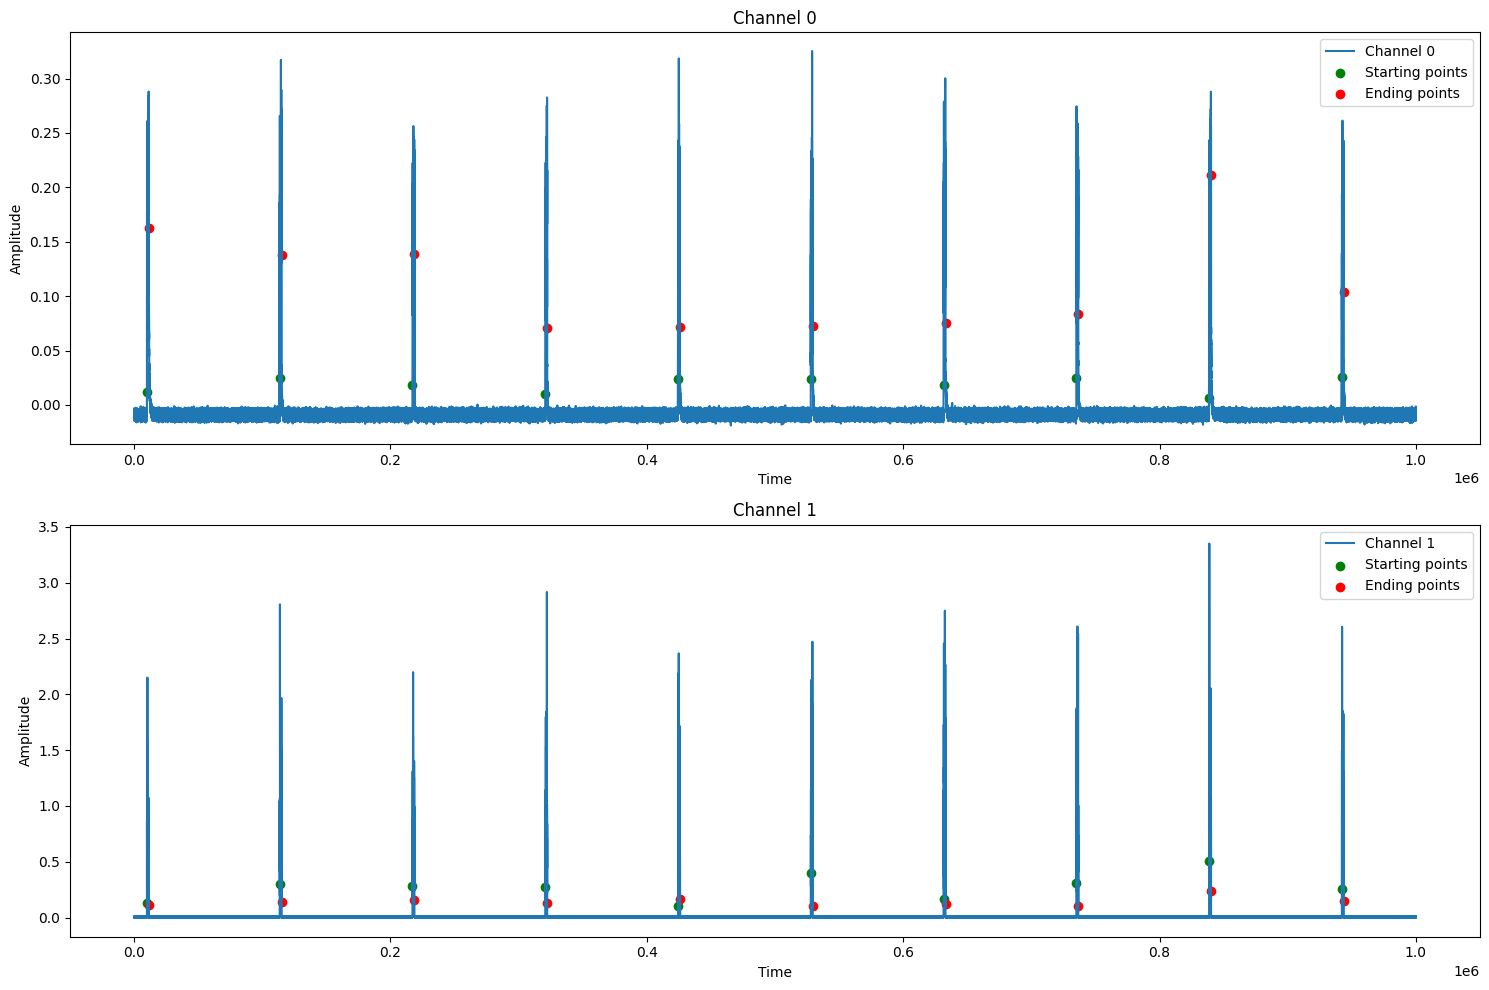

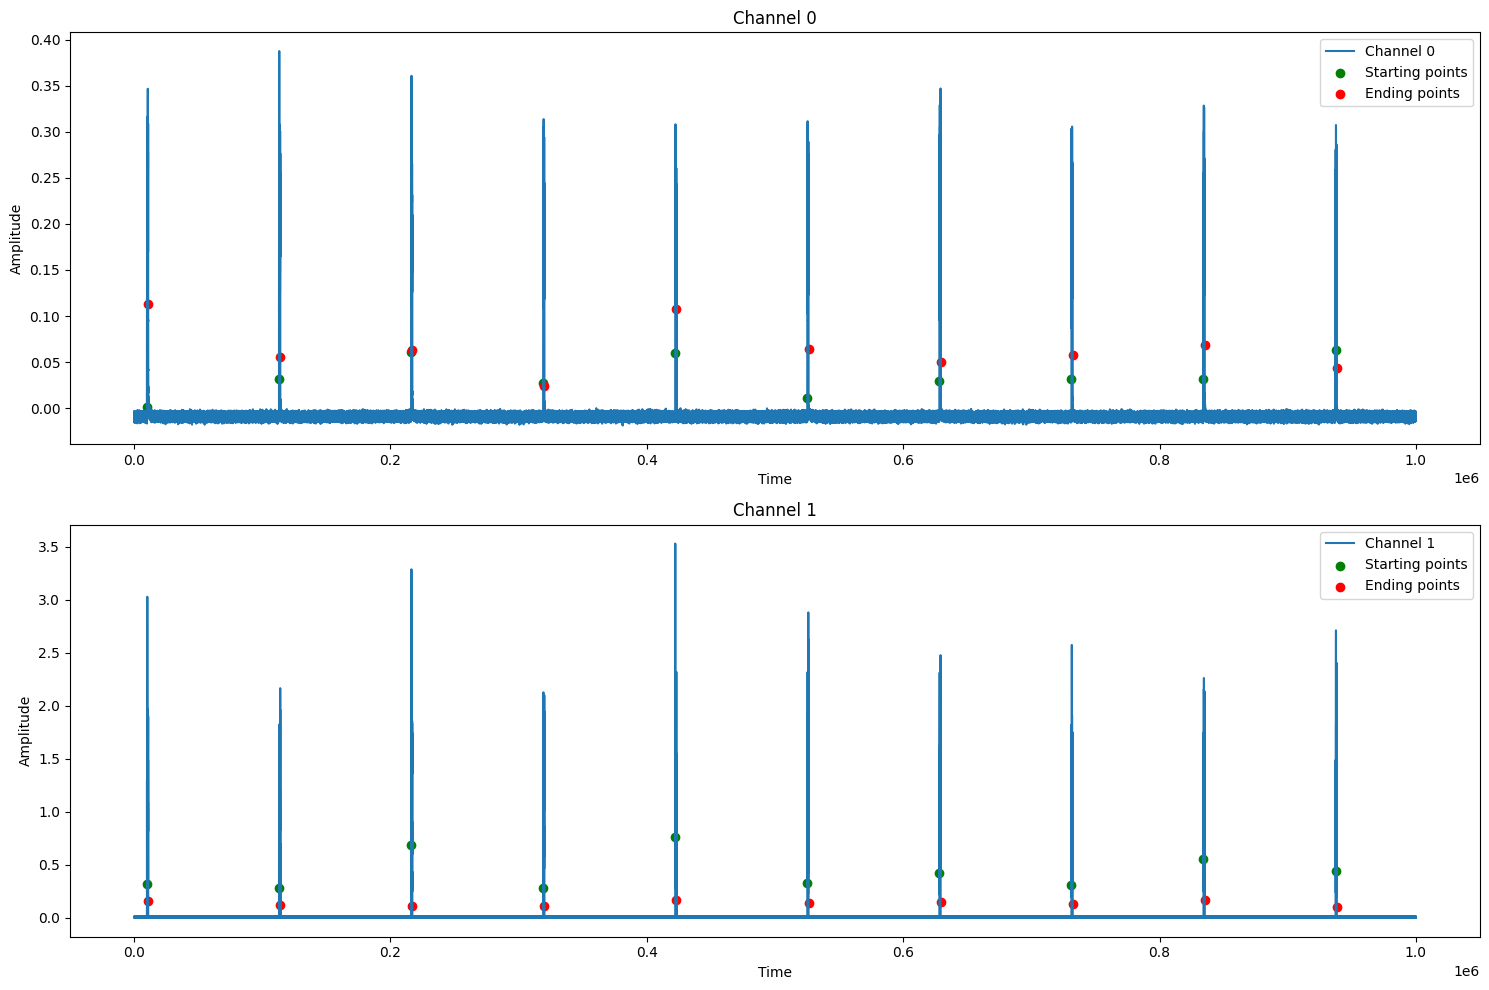

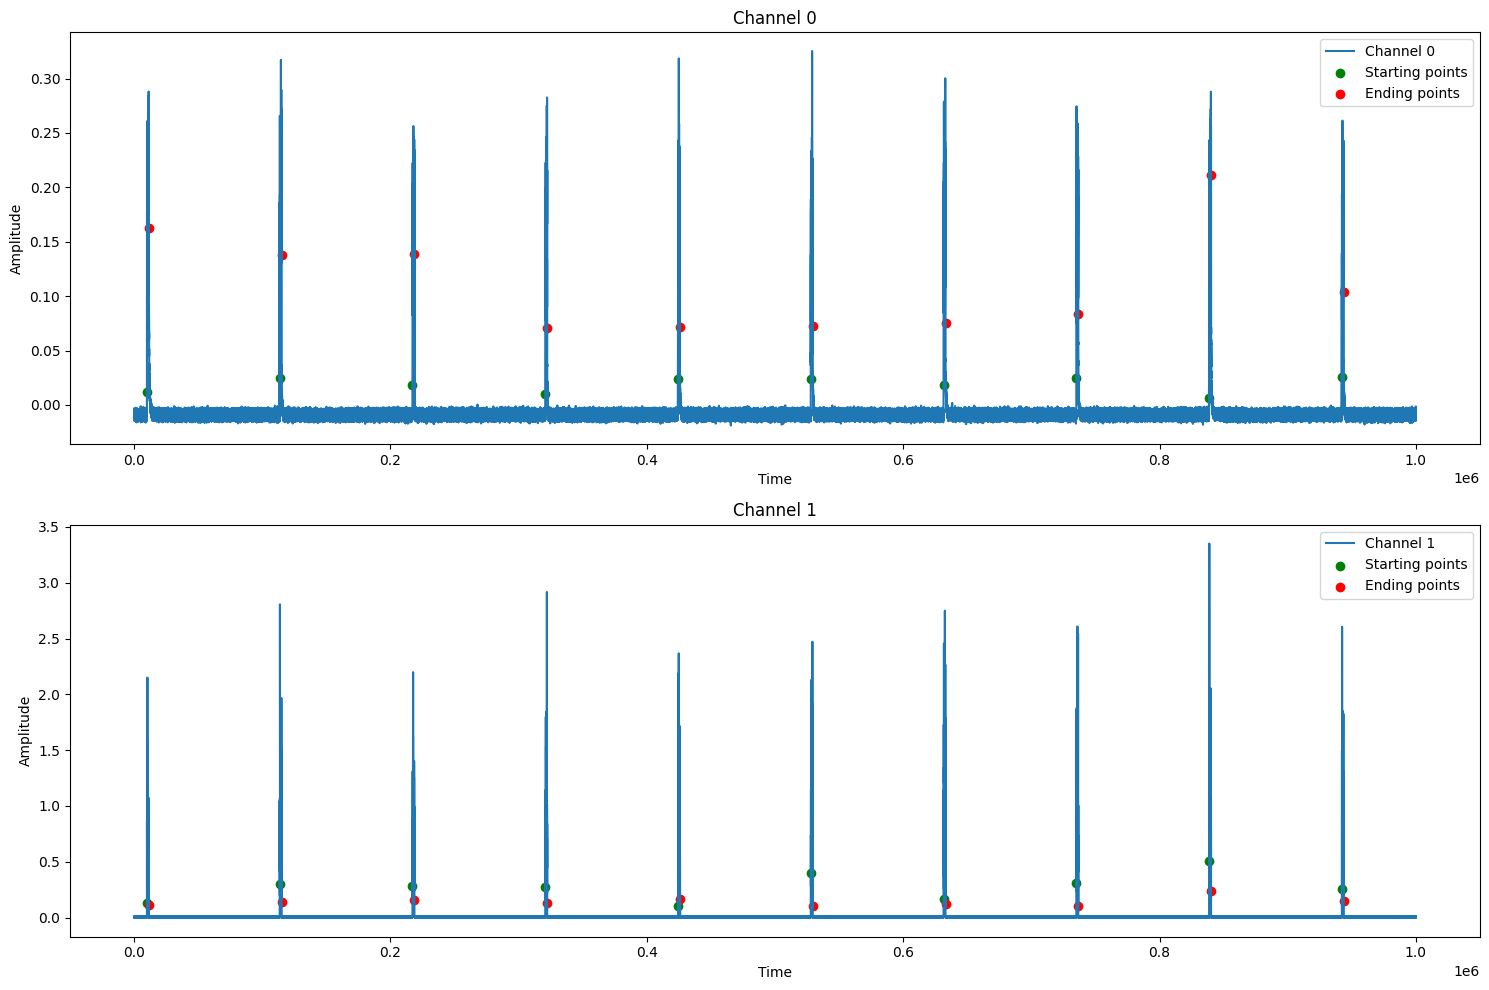

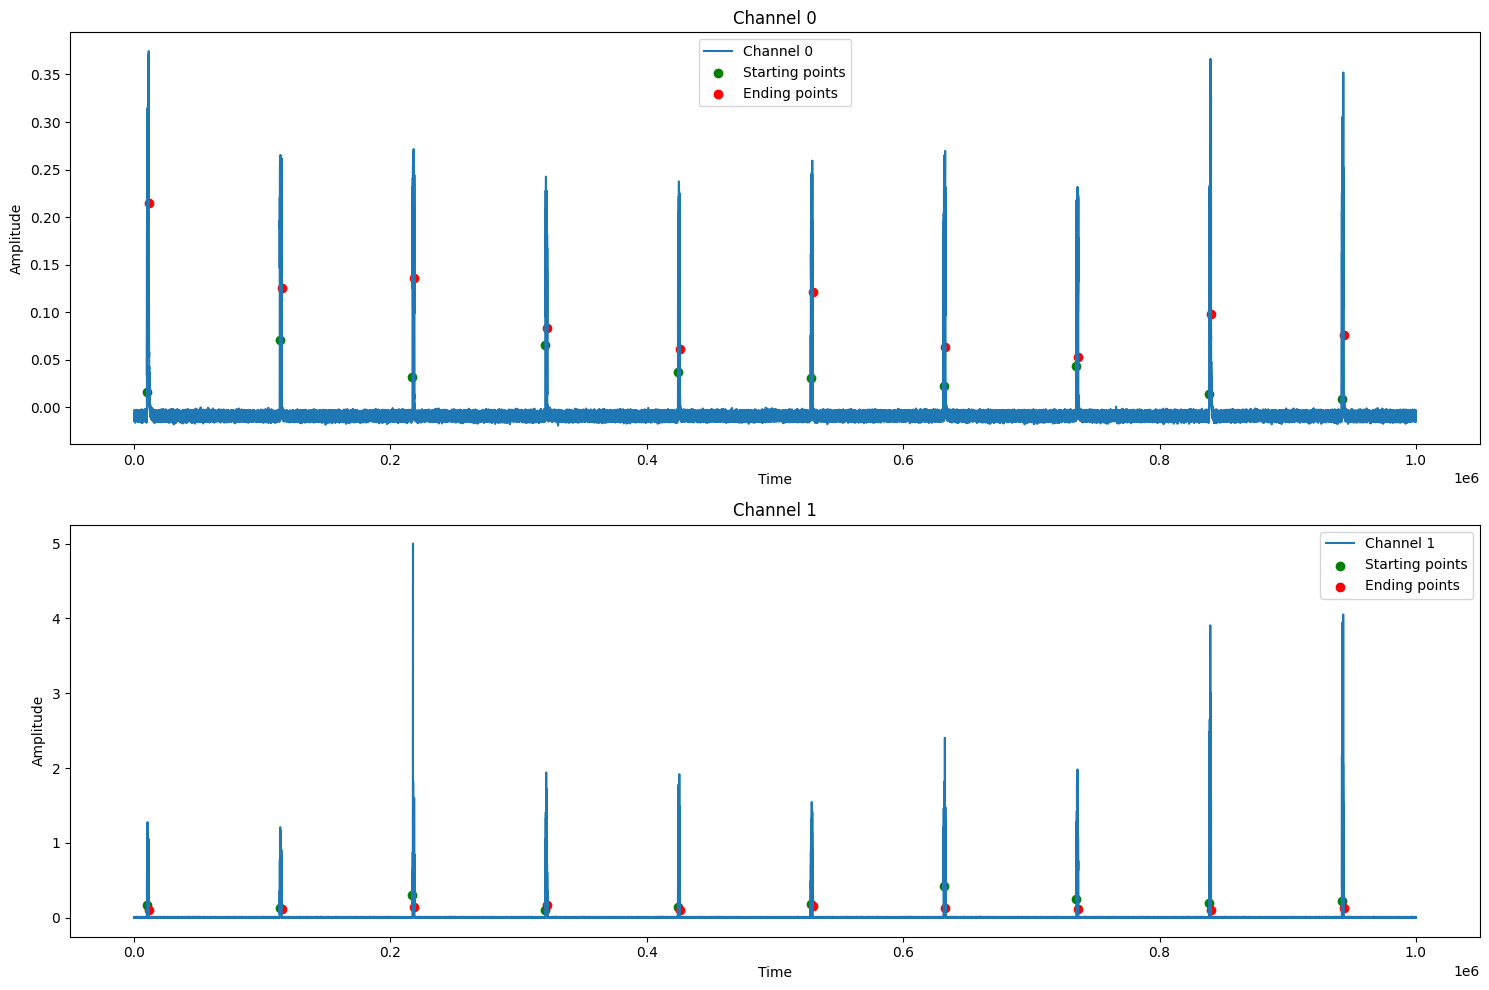

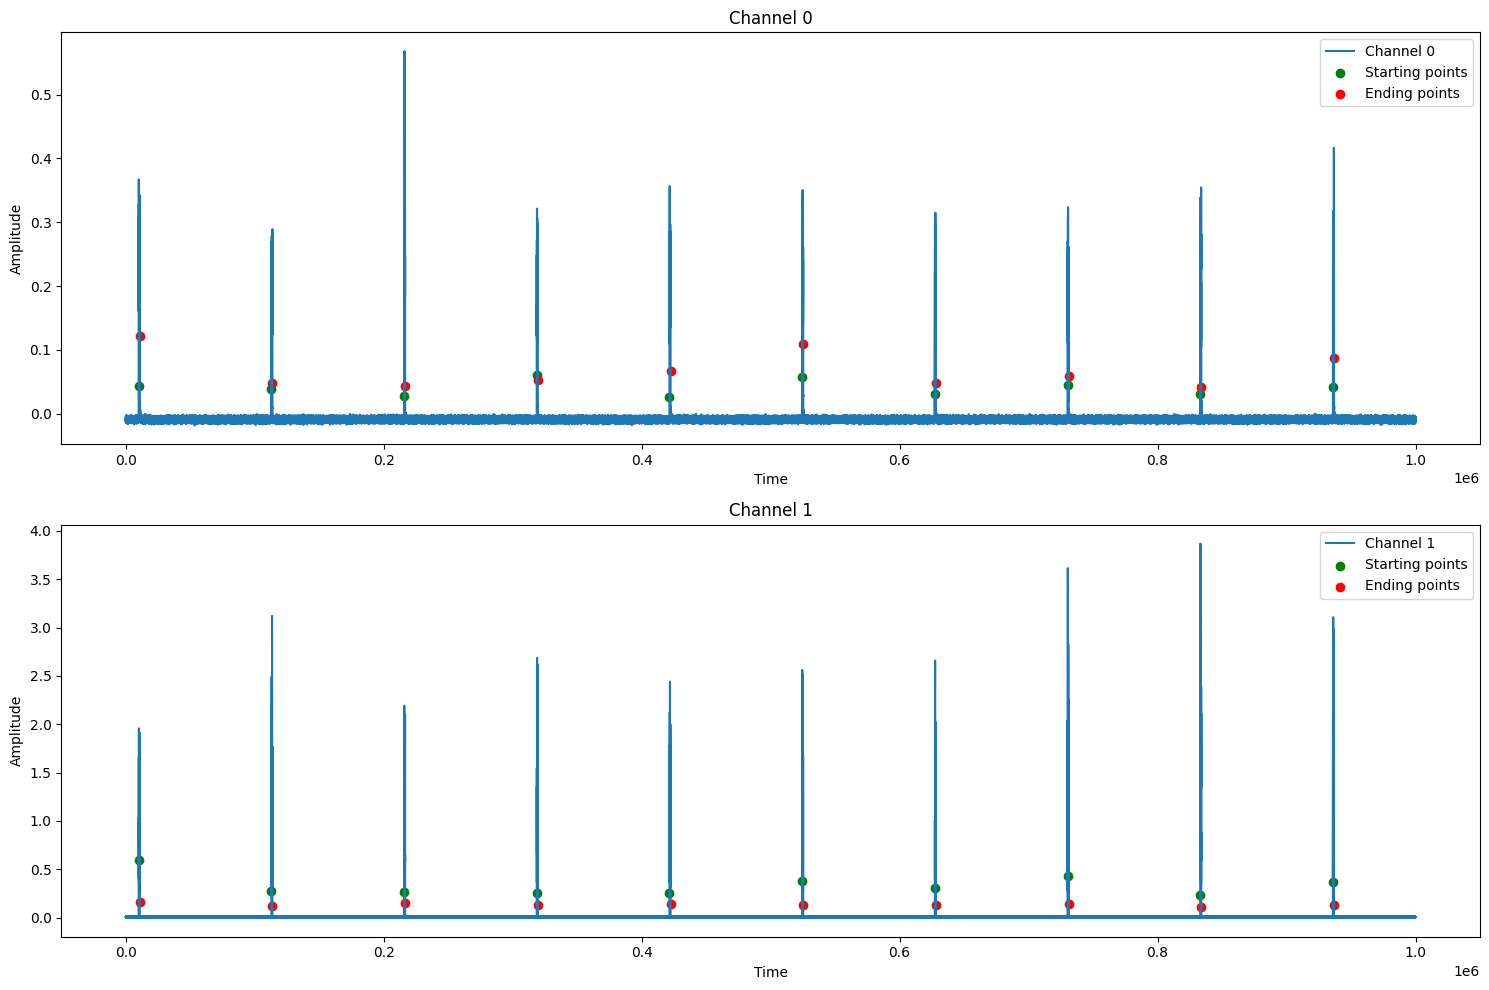

In [11]:
# Threshold value for computeBoundaries
th = 0.1  

# Generate 5 random integers between 0 and N_conditions
N_conditions = data_array.shape[0]  
random_conditions = np.random.randint(0, N_conditions, 5)

# Loop through the random conditions
for condition in random_conditions:
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition, 0, :]
    data_channel_1 = data_array[condition, 1, :]

    # Find the boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)

    # Plot the full-length signals along with the starting and ending points
    plot_signals_with_boundaries(data_channel_0, data_channel_1, starting_1, ending_1)

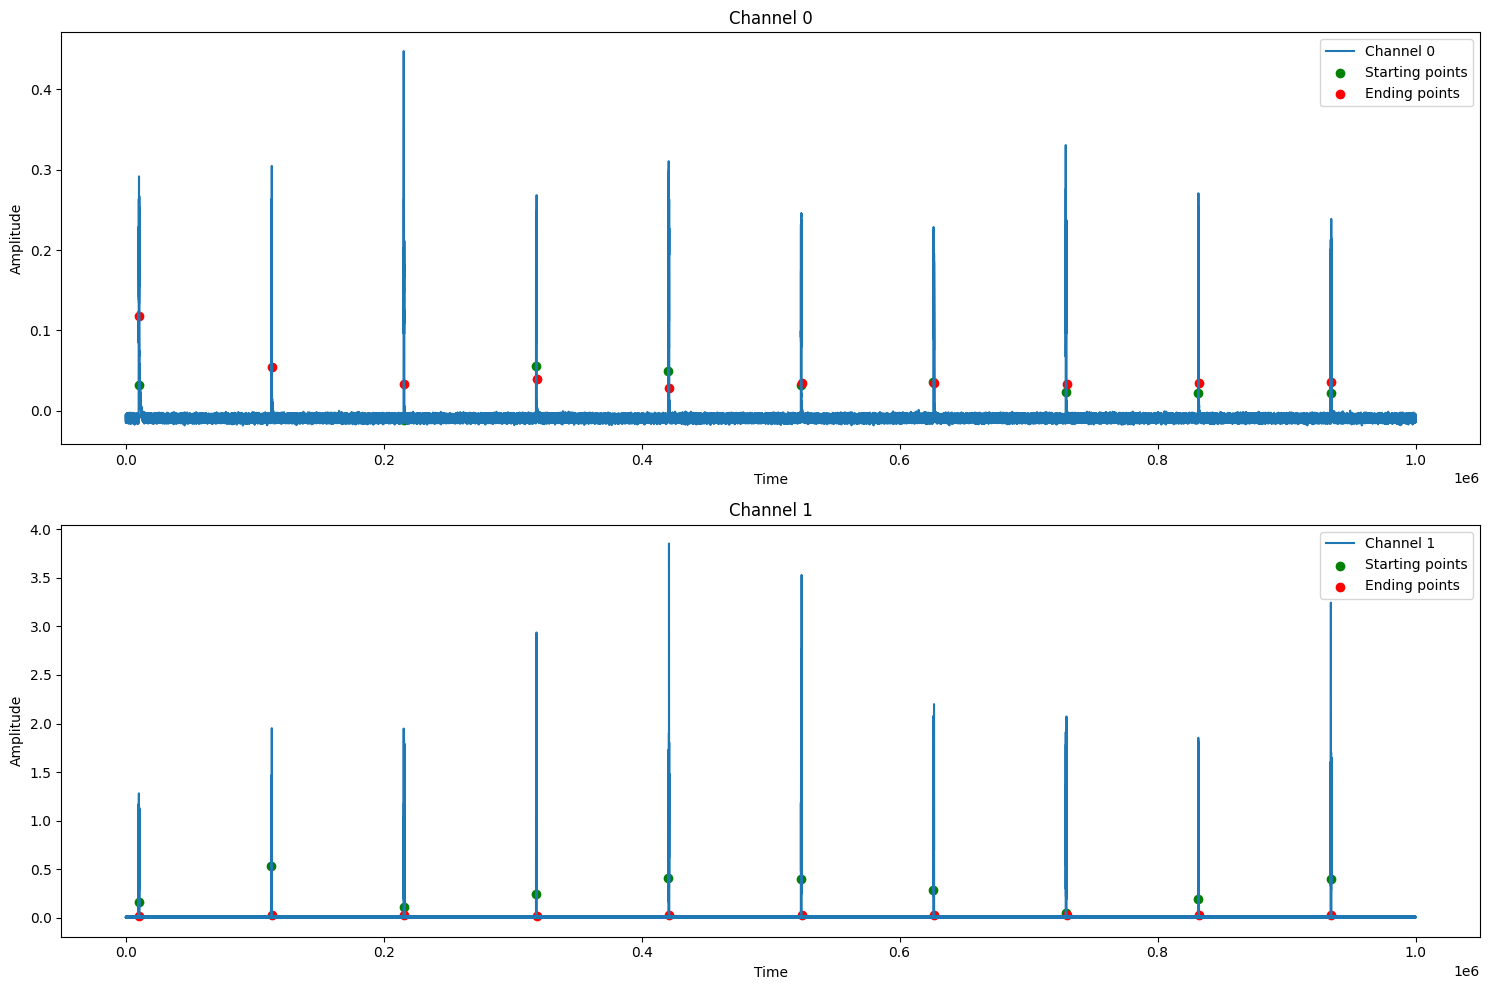

In [12]:
# Threshold value for computeBoundaries
th = 0.02 

# Ask for the condition number to plot
condition_to_plot = 13

# Check if the entered condition number is valid
if 0 <= condition_to_plot < N_conditions:
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition_to_plot, 0, :]
    data_channel_1 = data_array[condition_to_plot, 1, :]

    # Find the boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)

    # Plot the full-length signals along with the starting and ending points
    plot_signals_with_boundaries(data_channel_0, data_channel_1, starting_1, ending_1)
else:
    print("Invalid condition number. Please enter a number between 0 and {}.".format(N_conditions - 1))


In [13]:
# Initialize an empty list to collect segmented data for each condition
final_data_list = []

# Loop through all conditions
for condition in range(N_conditions):
    # Extract corresponding data for each channel
    data_channel_0 = data_array[condition, 0, :]
    data_channel_1 = data_array[condition, 1, :]

    # Compute boundaries using computeBoundaries() based on channel_1 data
    starting_1, ending_1 = computeBoundaries(data_channel_1, th)

    # Compute size of the segments
    size_segments = ending_1 - starting_1
    
    # Get the minimum size for this condition
    min_size = min(size_segments)

    # Check that each condition has exactly 10 segments
    n_segments = len(starting_1)
    if n_segments != 10:
        print(f"Condition {condition+1} does not have exactly 10 segments. It has {n_segments} segments.")
        continue

    # Segment both channels using these boundaries and minimum size
    segmented_0 = np.array([data_channel_0[end-min_size:end] for end in ending_1])
    segmented_1 = np.array([data_channel_1[end-min_size:end] for end in ending_1])

    # Combine the segmented data for both channels into one array
    condition_data = np.stack([segmented_0, segmented_1])

    # Append this condition data to the list
    final_data_list.append(condition_data)


Condition 2 does not have exactly 10 segments. It has 11 segments.


In [14]:
# Loop through final_data_list to print the dimensions of each array
for i, condition_data in enumerate(final_data_list):
    print(f"Dimensions of array for Condition {i}: {condition_data.shape}")


Dimensions of array for Condition 0: (2, 10, 965)
Dimensions of array for Condition 1: (2, 10, 630)
Dimensions of array for Condition 2: (2, 10, 1527)
Dimensions of array for Condition 3: (2, 10, 508)
Dimensions of array for Condition 4: (2, 10, 833)
Dimensions of array for Condition 5: (2, 10, 1201)
Dimensions of array for Condition 6: (2, 10, 720)
Dimensions of array for Condition 7: (2, 10, 720)
Dimensions of array for Condition 8: (2, 10, 1531)
Dimensions of array for Condition 9: (2, 10, 1531)
Dimensions of array for Condition 10: (2, 10, 987)
Dimensions of array for Condition 11: (2, 10, 835)
Dimensions of array for Condition 12: (2, 10, 635)
Dimensions of array for Condition 13: (2, 10, 2093)
Dimensions of array for Condition 14: (2, 10, 566)
Dimensions of array for Condition 15: (2, 10, 2094)
Dimensions of array for Condition 16: (2, 10, 835)
Dimensions of array for Condition 17: (2, 10, 1201)
Dimensions of array for Condition 18: (2, 10, 3285)
Dimensions of array for Condition

In [15]:
import pickle

# Specify the filename
filename = f'./Data/final_data_list_cube_{cube}.pkl'

# Open the file in write-binary mode and save final_data_list
with open(filename, 'wb') as f:
    pickle.dump(final_data_list, f)

print(f"final_data_list has been saved to {filename}")


final_data_list has been saved to ./Data/final_data_list_cube_2.pkl


# Conclusion and Future Steps

## Conclusion

Through this notebook, we have successfully visualized, preprocessed, and stored the LPBF experiment data. The data from each cube was inspected to ensure its integrity and was then shaped to conform to a standardized format. This standardization is crucial for conducting any future machine learning or statistical analyses.

Segmentation of the signals was performed based on the optical reflection channel, with the same segments being applied to the optical emission channel. Finally, all the segmented and processed data were saved for future use.

## Lessons Learned
- Data visualization is a crucial step in understanding the dataset's nuances.
- Preprocessing steps like cropping and padding can significantly impact the quality of subsequent analyses.

## Future Steps
1. **Statistical Analysis**: To further analyze the processed data to discern patterns or transitions in the melting regimes.
2. **Machine Learning Models**: To build predictive models that can determine melting regimes based on the collected data.
3. **Real-Time Monitoring**: To implement these analyses in a real-time monitoring system for LPBF processes.

By achieving the objectives outlined in the introduction, this notebook serves as a comprehensive guide and toolkit for anyone looking to process and analyze LPBF data.
